# CheckWatt Monthly Battery Analysis

This notebook analyzes monthly CheckWatt battery performance and cost savings.

## Analysis Overview

1. Load CheckWatt data for entire month (December 2025)
2. Load spot prices for the same period
3. Calculate battery efficiency metrics
4. Analyze State of Charge (SoC) statistics
5. Calculate monthly cost savings with 15-min and 1-hour netting
6. Visualize daily and monthly trends

## Battery Metrics

- **Battery Efficiency**: Total discharge / Total charge (round-trip efficiency)
- **SoC Statistics**: Min, max, average, daily patterns
- **Energy Flows**: Daily breakdown of import, export, solar, battery usage
- **Cost Savings**: Actual vs theoretical costs with and without battery

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pytz
from influxdb_client import InfluxDBClient
import sys
import os

# Add src to path for imports
sys.path.append(os.path.abspath('..'))
from src.common.config import get_config

# Setup plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)

print('Libraries imported successfully')

Libraries imported successfully


In [2]:
# Configuration
config = get_config()

# Month to analyze (December 2025)
TARGET_YEAR = 2025
TARGET_MONTH = 12
LOCAL_TZ = pytz.timezone('Europe/Helsinki')

# Calculate month start and end
start_local = LOCAL_TZ.localize(datetime(TARGET_YEAR, TARGET_MONTH, 1))
if TARGET_MONTH == 12:
    end_local = LOCAL_TZ.localize(datetime(TARGET_YEAR + 1, 1, 1))
else:
    end_local = LOCAL_TZ.localize(datetime(TARGET_YEAR, TARGET_MONTH + 1, 1))

start_utc = start_local.astimezone(pytz.utc)
end_utc = end_local.astimezone(pytz.utc)

num_days = (end_local - start_local).days

print(f'Analysis period (local): {start_local} to {end_local}')
print(f'Analysis period (UTC): {start_utc} to {end_utc}')
print(f'Number of days: {num_days}')

Analysis period (local): 2025-12-01 00:00:00+02:00 to 2026-01-01 00:00:00+02:00
Analysis period (UTC): 2025-11-30 22:00:00+00:00 to 2025-12-31 22:00:00+00:00
Number of days: 31


In [3]:
# Connect to InfluxDB
influx_client = InfluxDBClient(
    url=config.influxdb_url,
    token=config.influxdb_token,
    org=config.influxdb_org
)

query_api = influx_client.query_api()

print('Connected to InfluxDB successfully')

Connected to InfluxDB successfully


## Load CheckWatt Data

In [4]:
# Query CheckWatt data for the month
checkwatt_query = f'''
from(bucket: "{config.influxdb_bucket_checkwatt.replace("_test", "")}")
  |> range(start: {start_utc.strftime("%Y-%m-%dT%H:%M:%SZ")}, stop: {end_utc.strftime("%Y-%m-%dT%H:%M:%SZ")})
  |> filter(fn: (r) => r["_measurement"] == "checkwatt")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
'''

print('Fetching CheckWatt data (this may take a moment for a full month)...')
checkwatt_result = query_api.query(checkwatt_query)

# Convert to DataFrame
checkwatt_data = []
for table in checkwatt_result:
    for record in table.records:
        checkwatt_data.append({
            'time': record.get_time(),
            'Battery_SoC': record.values.get('Battery_SoC'),
            'BatteryCharge': record.values.get('BatteryCharge'),
            'BatteryDischarge': record.values.get('BatteryDischarge'),
            'EnergyImport': record.values.get('EnergyImport'),
            'EnergyExport': record.values.get('EnergyExport'),
            'SolarYield': record.values.get('SolarYield')
        })

df_checkwatt = pd.DataFrame(checkwatt_data)

# Convert to local timezone
df_checkwatt['time_local'] = df_checkwatt['time'].dt.tz_convert(LOCAL_TZ)

# Fill NaN values with 0
for col in ['BatteryCharge', 'BatteryDischarge', 'EnergyImport', 'EnergyExport', 'SolarYield']:
    df_checkwatt[col] = df_checkwatt[col].fillna(0)

print(f'Loaded {len(df_checkwatt)} CheckWatt data points')
print(f'Expected: ~{num_days * 1440} points (1 per minute)')
print(f'Time range: {df_checkwatt["time_local"].min()} to {df_checkwatt["time_local"].max()}')
df_checkwatt.head()

Fetching CheckWatt data (this may take a moment for a full month)...
Loaded 44443 CheckWatt data points
Expected: ~44640 points (1 per minute)
Time range: 2025-12-01 00:00:00+02:00 to 2025-12-31 23:59:00+02:00


,time,Battery_SoC,BatteryCharge,BatteryDischarge,EnergyImport,EnergyExport,SolarYield,time_local
0,2025-11-30 22:00:00+00:00,31.0,0.0,0.0,1080.0,0.0,0.0,2025-12-01 00:00:00+02:00
1,2025-11-30 22:01:00+00:00,31.0,0.0,0.0,1080.0,0.0,0.0,2025-12-01 00:01:00+02:00
2,2025-11-30 22:02:00+00:00,31.0,0.0,0.0,1020.0,0.0,0.0,2025-12-01 00:02:00+02:00
3,2025-11-30 22:03:00+00:00,31.0,0.0,0.0,1020.0,0.0,0.0,2025-12-01 00:03:00+02:00
4,2025-11-30 22:04:00+00:00,31.0,0.0,0.0,1080.0,0.0,0.0,2025-12-01 00:04:00+02:00


## Load Spot Prices

In [5]:
# Query spot prices
spotprice_query = f'''
from(bucket: "{config.influxdb_bucket_spotprice.replace("_test", "")}")
  |> range(start: {start_utc.strftime("%Y-%m-%dT%H:%M:%SZ")}, stop: {end_utc.strftime("%Y-%m-%dT%H:%M:%SZ")})
  |> filter(fn: (r) => r["_measurement"] == "spot")
  |> filter(fn: (r) => r["_field"] == "price_total")
'''

spotprice_result = query_api.query(spotprice_query)

# Convert to DataFrame
spotprice_data = []
for table in spotprice_result:
    for record in table.records:
        spotprice_data.append({
            'time': record.get_time(),
            'price_total': record.get_value()
        })

df_spotprice = pd.DataFrame(spotprice_data)

# Convert to local timezone
df_spotprice['time_local'] = df_spotprice['time'].dt.tz_convert(LOCAL_TZ)

print(f'Loaded {len(df_spotprice)} spot price data points')
print(f'Expected: ~{num_days * 96} points (4 per hour)')
print(f'Time range: {df_spotprice["time_local"].min()} to {df_spotprice["time_local"].max()}')
print(f'Price range: {df_spotprice["price_total"].min():.4f} - {df_spotprice["price_total"].max():.4f} EUR/kWh')
df_spotprice.head()

Loaded 2976 spot price data points
Expected: ~2976 points (4 per hour)
Time range: 2025-12-01 00:00:00+02:00 to 2025-12-31 23:45:00+02:00
Price range: 0.0462 - 0.2943 EUR/kWh


,time,price_total,time_local
0,2025-11-30 22:00:00+00:00,0.079737,2025-12-01 00:00:00+02:00
1,2025-11-30 22:15:00+00:00,0.073737,2025-12-01 00:15:00+02:00
2,2025-11-30 22:30:00+00:00,0.069737,2025-12-01 00:30:00+02:00
3,2025-11-30 22:45:00+00:00,0.065637,2025-12-01 00:45:00+02:00
4,2025-11-30 23:00:00+00:00,0.073337,2025-12-01 01:00:00+02:00


## Convert Power to Energy

CheckWatt values are average Watts per minute, convert to Watt-hours.

In [6]:
# Convert power (W) to energy (Wh) for 1-minute intervals
# Energy (Wh) = Power (W) * Time (h) = Power (W) / 60

df_checkwatt['SolarYield_Wh'] = df_checkwatt['SolarYield'] / 60.0
df_checkwatt['BatteryDischarge_Wh'] = df_checkwatt['BatteryDischarge'] / 60.0
df_checkwatt['BatteryCharge_Wh'] = df_checkwatt['BatteryCharge'] / 60.0
df_checkwatt['EnergyImport_Wh'] = df_checkwatt['EnergyImport'] / 60.0
df_checkwatt['EnergyExport_Wh'] = df_checkwatt['EnergyExport'] / 60.0

# Calculate home consumption
df_checkwatt['HomeConsumption'] = (
    df_checkwatt['SolarYield_Wh'] +
    df_checkwatt['BatteryDischarge_Wh'] +
    df_checkwatt['EnergyImport_Wh'] -
    df_checkwatt['BatteryCharge_Wh'] -
    df_checkwatt['EnergyExport_Wh']
)

print('Energy conversion completed')
print(f'Total consumption: {df_checkwatt["HomeConsumption"].sum() / 1000:.2f} kWh')
print(f'Total solar yield: {df_checkwatt["SolarYield_Wh"].sum() / 1000:.2f} kWh')
print(f'Total grid import: {df_checkwatt["EnergyImport_Wh"].sum() / 1000:.2f} kWh')
print(f'Total grid export: {df_checkwatt["EnergyExport_Wh"].sum() / 1000:.2f} kWh')
print(f'Total battery charge: {df_checkwatt["BatteryCharge_Wh"].sum() / 1000:.2f} kWh')
print(f'Total battery discharge: {df_checkwatt["BatteryDischarge_Wh"].sum() / 1000:.2f} kWh')

Energy conversion completed
Total consumption: 2091.20 kWh
Total solar yield: 27.12 kWh
Total grid import: 2067.74 kWh
Total grid export: 2.38 kWh
Total battery charge: 141.98 kWh
Total battery discharge: 140.70 kWh


## Battery Efficiency Analysis

In [7]:
# Calculate battery efficiency (round-trip efficiency)
total_charge_kwh = df_checkwatt['BatteryCharge_Wh'].sum() / 1000.0
total_discharge_kwh = df_checkwatt['BatteryDischarge_Wh'].sum() / 1000.0

# Max battery power (in Watts - original values before /60 conversion)
max_charge_watts = df_checkwatt['BatteryCharge'].max()
max_discharge_watts = df_checkwatt['BatteryDischarge'].max()

if total_charge_kwh > 0:
    battery_efficiency = (total_discharge_kwh / total_charge_kwh) * 100
else:
    battery_efficiency = 0

print('\n=== BATTERY EFFICIENCY ===')
print(f'Total battery charge: {total_charge_kwh:.2f} kWh')
print(f'Total battery discharge: {total_discharge_kwh:.2f} kWh')
print(f'Round-trip efficiency: {battery_efficiency:.1f}%')
print(f'Energy loss in battery: {total_charge_kwh - total_discharge_kwh:.2f} kWh')

print('\n=== BATTERY POWER LIMITS ===')
print(f'Max charge power: {max_charge_watts:.0f} W ({max_charge_watts/1000:.2f} kW)')
print(f'Max discharge power: {max_discharge_watts:.0f} W ({max_discharge_watts/1000:.2f} kW)')
print(f'Inverter rated power: 10.0 kW')
print(f'Max charge utilization: {(max_charge_watts/10000)*100:.1f}% of inverter capacity')
print(f'Max discharge utilization: {(max_discharge_watts/10000)*100:.1f}% of inverter capacity')

# Battery cycles (using actual battery capacity)
BATTERY_CAPACITY_KWH = 20.0
INVERTER_POWER_KW = 10.0
battery_cycles = total_discharge_kwh / BATTERY_CAPACITY_KWH
print(f'\n=== BATTERY CYCLES ===')
print(f'Battery capacity: {BATTERY_CAPACITY_KWH} kWh')
print(f'Estimated battery cycles: {battery_cycles:.1f} cycles')


=== BATTERY EFFICIENCY ===
Total battery charge: 141.98 kWh
Total battery discharge: 140.70 kWh
Round-trip efficiency: 99.1%
Energy loss in battery: 1.28 kWh

=== BATTERY POWER LIMITS ===
Max charge power: 8760 W (8.76 kW)
Max discharge power: 8280 W (8.28 kW)
Inverter rated power: 10.0 kW
Max charge utilization: 87.6% of inverter capacity
Max discharge utilization: 82.8% of inverter capacity

=== BATTERY CYCLES ===
Battery capacity: 20.0 kWh
Estimated battery cycles: 7.0 cycles


## State of Charge (SoC) Analysis


=== STATE OF CHARGE STATISTICS ===
Minimum SoC: 26.0%
Maximum SoC: 74.0%
Average SoC: 54.2%
Median SoC: 62.0%


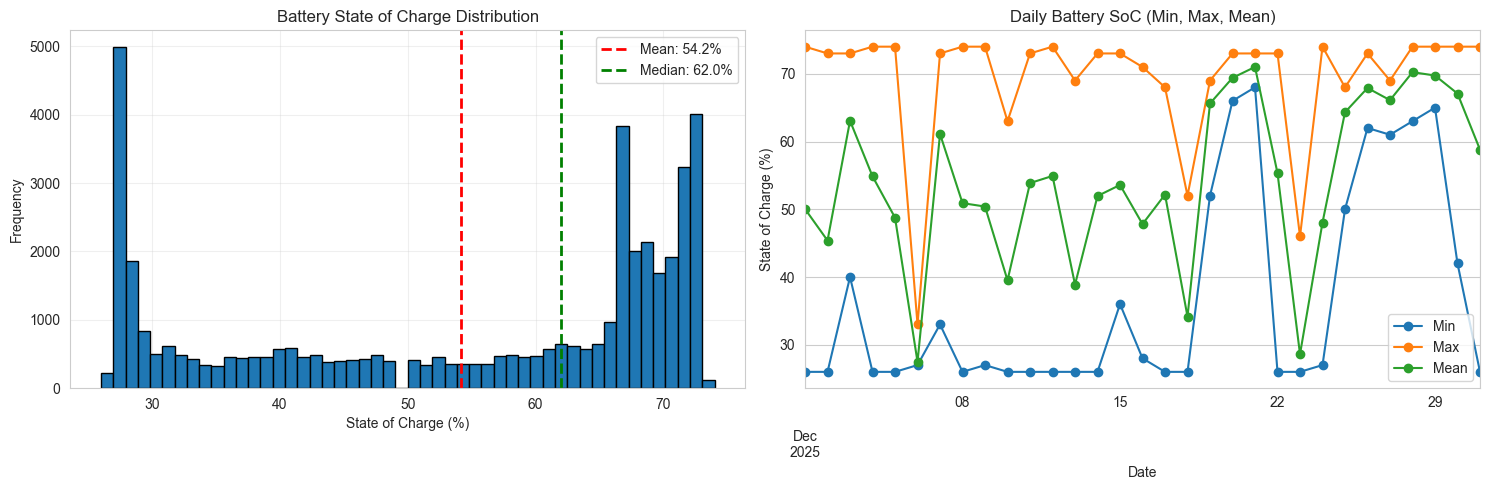

In [8]:
# SoC statistics
soc_min = df_checkwatt['Battery_SoC'].min()
soc_max = df_checkwatt['Battery_SoC'].max()
soc_mean = df_checkwatt['Battery_SoC'].mean()
soc_median = df_checkwatt['Battery_SoC'].median()

print('\n=== STATE OF CHARGE STATISTICS ===')
print(f'Minimum SoC: {soc_min:.1f}%')
print(f'Maximum SoC: {soc_max:.1f}%')
print(f'Average SoC: {soc_mean:.1f}%')
print(f'Median SoC: {soc_median:.1f}%')

# Plot SoC distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
ax1 = axes[0]
df_checkwatt['Battery_SoC'].hist(bins=50, ax=ax1, edgecolor='black')
ax1.axvline(soc_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {soc_mean:.1f}%')
ax1.axvline(soc_median, color='green', linestyle='--', linewidth=2, label=f'Median: {soc_median:.1f}%')
ax1.set_xlabel('State of Charge (%)')
ax1.set_ylabel('Frequency')
ax1.set_title('Battery State of Charge Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Time series (daily aggregation for readability)
ax2 = axes[1]
df_daily_soc = df_checkwatt.set_index('time_local')['Battery_SoC'].resample('1D').agg(['min', 'max', 'mean'])
df_daily_soc.plot(ax=ax2, marker='o')
ax2.set_ylabel('State of Charge (%)')
ax2.set_xlabel('Date')
ax2.set_title('Daily Battery SoC (Min, Max, Mean)')
ax2.legend(['Min', 'Max', 'Mean'])
ax2.grid(True)

plt.tight_layout()
plt.show()

## SoC Accuracy Validation

Validate the accuracy of Battery SoC measurements by comparing calculated energy flows with reported SoC changes.

In [9]:
# Validate SoC accuracy by comparing with energy flows
# Calculate expected SoC change based on charge/discharge energy

# Get initial and final SoC
initial_soc = df_checkwatt['Battery_SoC'].iloc[0]
final_soc = df_checkwatt['Battery_SoC'].iloc[-1]
measured_soc_change = final_soc - initial_soc

# Calculate net energy flow (charge - discharge)
# Positive = net charge (SoC increases), Negative = net discharge (SoC decreases)
net_energy_kwh = total_charge_kwh - total_discharge_kwh

# Calculate expected SoC change from energy flows
# SoC change (%) = (Energy change (kWh) / Battery capacity (kWh)) * 100
expected_soc_change = (net_energy_kwh / BATTERY_CAPACITY_KWH) * 100

# Calculate discrepancy
soc_discrepancy = measured_soc_change - expected_soc_change
soc_discrepancy_kwh = (soc_discrepancy / 100) * BATTERY_CAPACITY_KWH

print('\n=== SOC ACCURACY VALIDATION ===')
print(f'Battery capacity: {BATTERY_CAPACITY_KWH} kWh')
print(f'\nInitial SoC: {initial_soc:.1f}%')
print(f'Final SoC: {final_soc:.1f}%')
print(f'Measured SoC change: {measured_soc_change:+.1f}%')
print(f'\nTotal battery charge: {total_charge_kwh:.2f} kWh')
print(f'Total battery discharge: {total_discharge_kwh:.2f} kWh')
print(f'Net energy flow (charge - discharge): {net_energy_kwh:+.2f} kWh')
print(f'\nExpected SoC change from energy: {expected_soc_change:+.1f}%')
print(f'SoC measurement discrepancy: {soc_discrepancy:+.1f}%')
print(f'Energy equivalent of discrepancy: {soc_discrepancy_kwh:+.2f} kWh')
print(f'\nSoC accuracy: {100 - abs(soc_discrepancy/measured_soc_change*100) if measured_soc_change != 0 else 0:.1f}%')

# Analyze hourly SoC changes vs energy flows
df_soc_analysis = df_checkwatt.set_index('time_local').copy()
df_soc_analysis['SoC_change'] = df_soc_analysis['Battery_SoC'].diff()
df_soc_analysis['Net_energy_Wh'] = (
    df_soc_analysis['BatteryCharge_Wh'] - df_soc_analysis['BatteryDischarge_Wh']
)
df_soc_analysis['Expected_SoC_change'] = (
    df_soc_analysis['Net_energy_Wh'] / (BATTERY_CAPACITY_KWH * 1000) * 100
)
df_soc_analysis['SoC_error'] = (
    df_soc_analysis['SoC_change'] - df_soc_analysis['Expected_SoC_change']
)

# Aggregate to hourly for cleaner analysis
df_hourly_soc = df_soc_analysis.resample('1H').agg({
    'SoC_change': 'sum',
    'Net_energy_Wh': 'sum',
    'Expected_SoC_change': 'sum',
    'SoC_error': 'sum'
})

# Calculate cumulative SoC from energy flows
df_hourly_soc['Cumulative_SoC_measured'] = initial_soc + df_hourly_soc['SoC_change'].cumsum()
df_hourly_soc['Cumulative_SoC_calculated'] = initial_soc + df_hourly_soc['Expected_SoC_change'].cumsum()
df_hourly_soc['Cumulative_error'] = (
    df_hourly_soc['Cumulative_SoC_measured'] - df_hourly_soc['Cumulative_SoC_calculated']
)

print(f'\nHourly analysis:')
print(f'Mean absolute SoC error per hour: {df_hourly_soc["SoC_error"].abs().mean():.3f}%')
print(f'Max absolute SoC error per hour: {df_hourly_soc["SoC_error"].abs().max():.3f}%')
print(f'RMS SoC error: {np.sqrt((df_hourly_soc["SoC_error"]**2).mean()):.3f}%')


=== SOC ACCURACY VALIDATION ===
Battery capacity: 20.0 kWh

Initial SoC: 31.0%
Final SoC: 69.0%
Measured SoC change: +38.0%

Total battery charge: 141.98 kWh
Total battery discharge: 140.70 kWh
Net energy flow (charge - discharge): +1.28 kWh

Expected SoC change from energy: +6.4%
SoC measurement discrepancy: +31.6%
Energy equivalent of discrepancy: +6.32 kWh

SoC accuracy: 16.8%

Hourly analysis:
Mean absolute SoC error per hour: 1.058%
Max absolute SoC error per hour: 42.235%
RMS SoC error: 2.079%


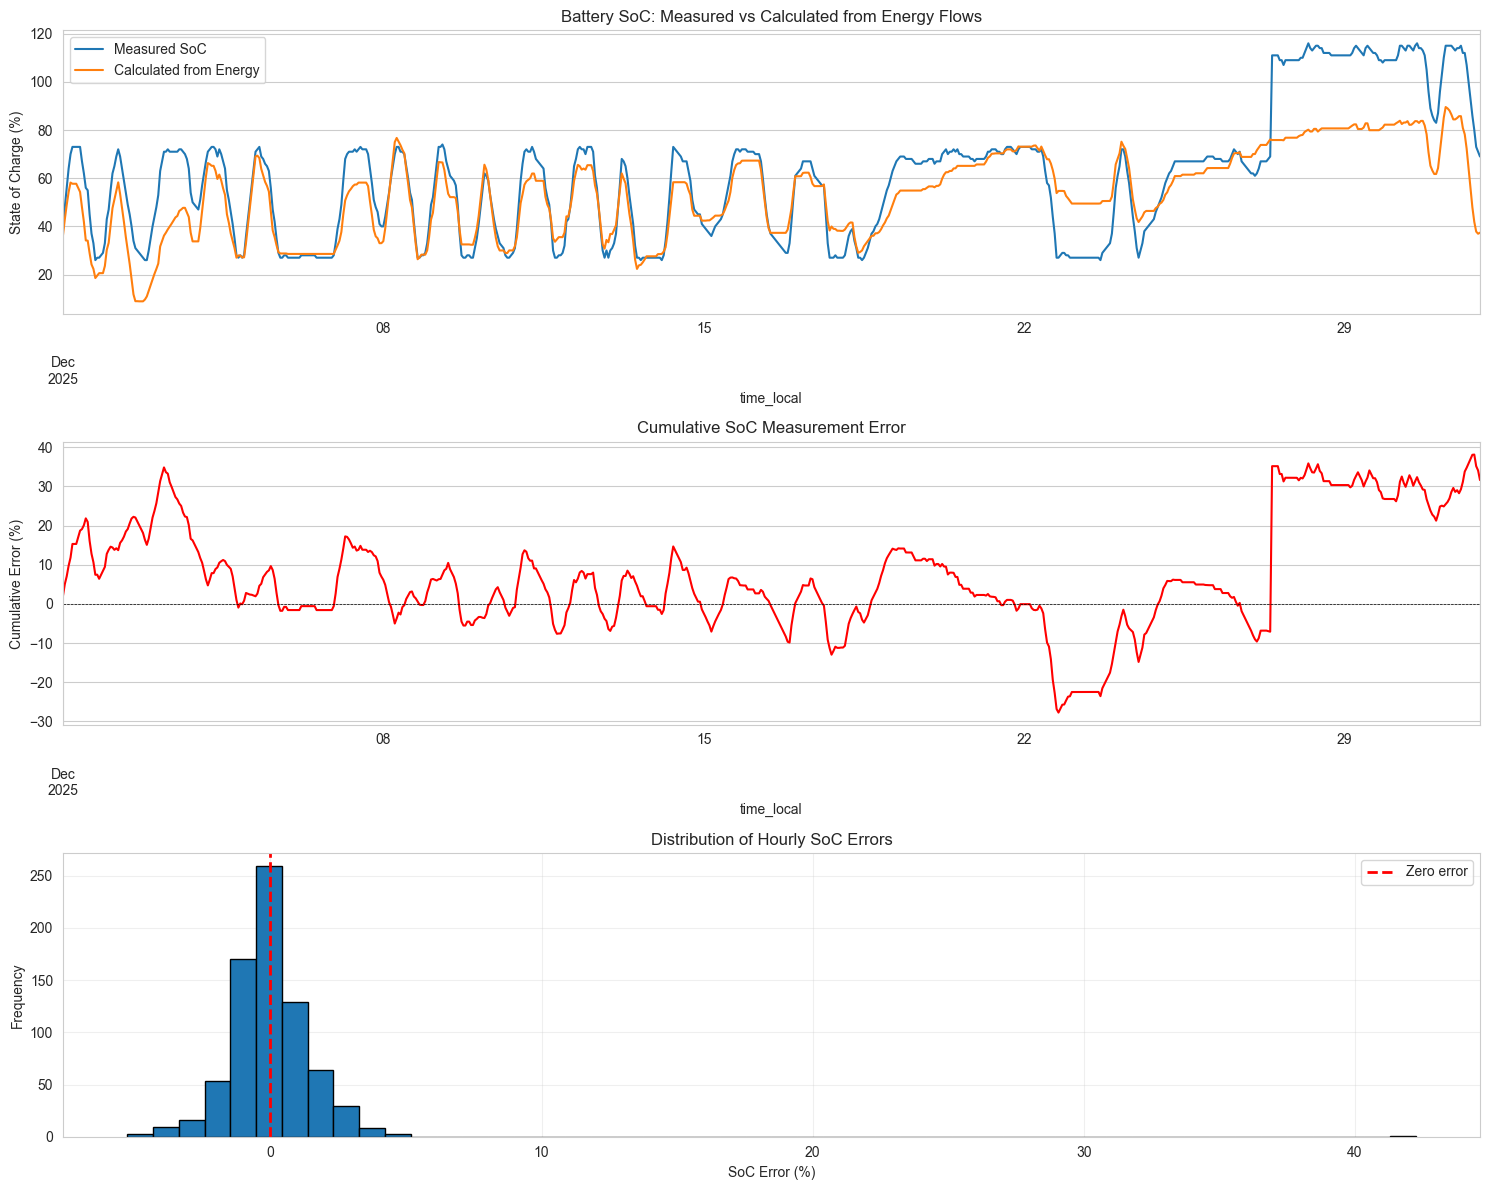


=== SOC ERROR STATISTICS ===
Mean error: +0.042%
Median error: +0.000%
Std deviation: 2.080%
95th percentile absolute error: 3.004%

=== ENERGY ACCOUNTING ===
Total energy discrepancy: +6.32 kWh
As percentage of total charge: +4.5%
As percentage of battery capacity: 31.6%

Possible causes:
  - Battery capacity may differ from nominal {BATTERY_CAPACITY_KWH} kWh
  - SoC sensor calibration drift
  - Unaccounted energy losses


In [10]:
# Visualize SoC accuracy
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Measured vs Calculated cumulative SoC
ax1 = axes[0]
df_hourly_soc[['Cumulative_SoC_measured', 'Cumulative_SoC_calculated']].plot(ax=ax1)
ax1.set_ylabel('State of Charge (%)')
ax1.set_title('Battery SoC: Measured vs Calculated from Energy Flows')
ax1.legend(['Measured SoC', 'Calculated from Energy'])
ax1.grid(True)

# Plot 2: Cumulative error over time
ax2 = axes[1]
df_hourly_soc['Cumulative_error'].plot(ax=ax2, color='red')
ax2.set_ylabel('Cumulative Error (%)')
ax2.set_title('Cumulative SoC Measurement Error')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax2.grid(True)

# Plot 3: Hourly SoC error distribution
ax3 = axes[2]
df_hourly_soc['SoC_error'].hist(bins=50, ax=ax3, edgecolor='black')
ax3.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
ax3.set_xlabel('SoC Error (%)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Hourly SoC Errors')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional statistics
print('\n=== SOC ERROR STATISTICS ===')
print(f'Mean error: {df_hourly_soc["SoC_error"].mean():+.3f}%')
print(f'Median error: {df_hourly_soc["SoC_error"].median():+.3f}%')
print(f'Std deviation: {df_hourly_soc["SoC_error"].std():.3f}%')
print(f'95th percentile absolute error: {df_hourly_soc["SoC_error"].abs().quantile(0.95):.3f}%')

# Energy loss analysis
print('\n=== ENERGY ACCOUNTING ===')
print(f'Total energy discrepancy: {soc_discrepancy_kwh:+.2f} kWh')
print(f'As percentage of total charge: {(soc_discrepancy_kwh/total_charge_kwh*100):+.1f}%')
print(f'As percentage of battery capacity: {(abs(soc_discrepancy_kwh)/BATTERY_CAPACITY_KWH*100):.1f}%')

# Check if discrepancy is systematic or random
if abs(soc_discrepancy) > 2.0:
    print(f'\nWARNING: Large SoC discrepancy detected ({soc_discrepancy:+.1f}%)')
    print('Possible causes:')
    print('  - Battery capacity may differ from nominal {BATTERY_CAPACITY_KWH} kWh')
    print('  - SoC sensor calibration drift')
    print('  - Unaccounted energy losses')
else:
    print(f'\nSoC measurements appear accurate (discrepancy: {soc_discrepancy:+.1f}%)')

In [11]:
# Merge CheckWatt and spot price data
df_checkwatt_indexed = df_checkwatt.set_index('time_local')
df_spotprice_indexed = df_spotprice.set_index('time_local')

df_merged = pd.merge_asof(
    df_checkwatt_indexed.sort_index(),
    df_spotprice_indexed[['price_total']].sort_index(),
    left_index=True,
    right_index=True,
    direction='backward'
)

print(f'Merged data: {len(df_merged)} rows')
print(f'Missing price data: {df_merged["price_total"].isna().sum()} rows')

Merged data: 44443 rows
Missing price data: 0 rows


In [12]:
def apply_netting_window(df, window_minutes):
    """
    Apply netting window to calculate costs.
    
    Args:
        df: DataFrame with minute-level data
        window_minutes: Window size in minutes (15 or 60)
    
    Returns:
        DataFrame with windowed data
    """
    df_window = df.resample(f'{window_minutes}min').agg({
        'Battery_SoC': 'last',
        'BatteryCharge_Wh': 'sum',
        'BatteryDischarge_Wh': 'sum',
        'EnergyImport_Wh': 'sum',
        'EnergyExport_Wh': 'sum',
        'SolarYield_Wh': 'sum',
        'HomeConsumption': 'sum',
        'price_total': 'mean'
    })
    
    # Net import with battery
    df_window['NetImport'] = df_window['EnergyImport_Wh'] - df_window['EnergyExport_Wh']
    
    # Cost with battery (Wh * EUR/kWh / 1000)
    df_window['Cost_WithBattery'] = df_window['NetImport'] * df_window['price_total'] / 1000.0
    
    # Theoretical scenario without battery
    df_window['Solar_to_Home'] = df_window[['SolarYield_Wh', 'HomeConsumption']].min(axis=1)
    df_window['Solar_to_Export'] = df_window['SolarYield_Wh'] - df_window['Solar_to_Home']
    df_window['Grid_to_Home'] = df_window['HomeConsumption'] - df_window['Solar_to_Home']
    df_window['NetImport_NoBattery'] = df_window['Grid_to_Home'] - df_window['Solar_to_Export']
    df_window['Cost_NoBattery'] = df_window['NetImport_NoBattery'] * df_window['price_total'] / 1000.0
    
    # Savings
    df_window['Savings'] = df_window['Cost_NoBattery'] - df_window['Cost_WithBattery']
    
    return df_window

print('Netting function defined')

Netting function defined


In [13]:
# Apply 15-minute netting
print('Applying 15-minute netting...')
df_15min = apply_netting_window(df_merged, 15)

print('\n=== 15-MINUTE NETTING RESULTS ===')
print(f'Total cost with battery: {df_15min["Cost_WithBattery"].sum():.2f} EUR')
print(f'Total cost without battery: {df_15min["Cost_NoBattery"].sum():.2f} EUR')
print(f'Total savings: {df_15min["Savings"].sum():.2f} EUR')
print(f'Savings percentage: {(df_15min["Savings"].sum() / df_15min["Cost_NoBattery"].sum() * 100):.1f}%')
print(f'Average daily savings: {df_15min["Savings"].sum() / num_days:.2f} EUR')

Applying 15-minute netting...

=== 15-MINUTE NETTING RESULTS ===
Total cost with battery: 178.73 EUR
Total cost without battery: 189.90 EUR
Total savings: 11.17 EUR
Savings percentage: 5.9%
Average daily savings: 0.36 EUR


## Merge Data and Apply Netting

In [14]:
## Merge Data and Apply Netting

In [15]:
# Apply 1-hour netting
print('Applying 1-hour netting...')
df_1hour = apply_netting_window(df_merged, 60)

print('\n=== 1-HOUR NETTING RESULTS ===')
print(f'Total cost with battery: {df_1hour["Cost_WithBattery"].sum():.2f} EUR')
print(f'Total cost without battery: {df_1hour["Cost_NoBattery"].sum():.2f} EUR')
print(f'Total savings: {df_1hour["Savings"].sum():.2f} EUR')
print(f'Savings percentage: {(df_1hour["Savings"].sum() / df_1hour["Cost_NoBattery"].sum() * 100):.1f}%')
print(f'Average daily savings: {df_1hour["Savings"].sum() / num_days:.2f} EUR')

Applying 1-hour netting...

=== 1-HOUR NETTING RESULTS ===
Total cost with battery: 179.47 EUR
Total cost without battery: 190.05 EUR
Total savings: 10.58 EUR
Savings percentage: 5.6%
Average daily savings: 0.34 EUR


## Daily Analysis

In [16]:
# Aggregate to daily data for analysis
df_daily_15min = df_15min.resample('1D').agg({
    'EnergyImport_Wh': 'sum',
    'EnergyExport_Wh': 'sum',
    'SolarYield_Wh': 'sum',
    'HomeConsumption': 'sum',
    'BatteryCharge_Wh': 'sum',
    'BatteryDischarge_Wh': 'sum',
    'Cost_WithBattery': 'sum',
    'Cost_NoBattery': 'sum',
    'Savings': 'sum',
    'price_total': 'mean'
})

# Convert to kWh
df_daily_15min['EnergyImport_kWh'] = df_daily_15min['EnergyImport_Wh'] / 1000
df_daily_15min['EnergyExport_kWh'] = df_daily_15min['EnergyExport_Wh'] / 1000
df_daily_15min['SolarYield_kWh'] = df_daily_15min['SolarYield_Wh'] / 1000
df_daily_15min['HomeConsumption_kWh'] = df_daily_15min['HomeConsumption'] / 1000
df_daily_15min['BatteryCharge_kWh'] = df_daily_15min['BatteryCharge_Wh'] / 1000
df_daily_15min['BatteryDischarge_kWh'] = df_daily_15min['BatteryDischarge_Wh'] / 1000

# Calculate daily efficiency
df_daily_15min['BatteryEfficiency'] = (
    df_daily_15min['BatteryDischarge_kWh'] / df_daily_15min['BatteryCharge_kWh'] * 100
).fillna(0)

print('Daily aggregation completed')
df_daily_15min.head()

Daily aggregation completed


,EnergyImport_Wh,EnergyExport_Wh,SolarYield_Wh,HomeConsumption,BatteryCharge_Wh,BatteryDischarge_Wh,Cost_WithBattery,Cost_NoBattery,Savings,price_total,EnergyImport_kWh,EnergyExport_kWh,SolarYield_kWh,HomeConsumption_kWh,BatteryCharge_kWh,BatteryDischarge_kWh,BatteryEfficiency
time_local,,,,,,,,,,,,,,,,,
2025-12-01 00:00:00+02:00,56402.0,51.0,317.0,56821.0,8010.0,8163.0,5.917795,6.488713,0.570917,0.119822,56.402,0.051,0.317,56.821,8.010,8.163,101.910112
2025-12-02 00:00:00+02:00,77461.0,117.0,1195.0,80994.0,7424.0,9879.0,6.221703,7.195981,0.974278,0.108374,77.461,0.117,1.195,80.994,7.424,9.879,133.068427
2025-12-03 00:00:00+02:00,95048.0,52.0,395.0,92227.0,6023.0,2859.0,6.830687,6.826863,-0.003824,0.077655,95.048,0.052,0.395,92.227,6.023,2.859,47.468039
2025-12-04 00:00:00+02:00,48869.0,7.0,315.0,50498.0,7455.0,8776.0,6.486819,7.753620,1.266801,0.173431,48.869,0.007,0.315,50.498,7.455,8.776,117.719651
2025-12-05 00:00:00+02:00,46692.0,64.0,581.0,46931.0,8900.0,8622.0,7.832604,8.723133,0.890528,0.202384,46.692,0.064,0.581,46.931,8.900,8.622,96.876404


## Visualization: Daily Energy Flows

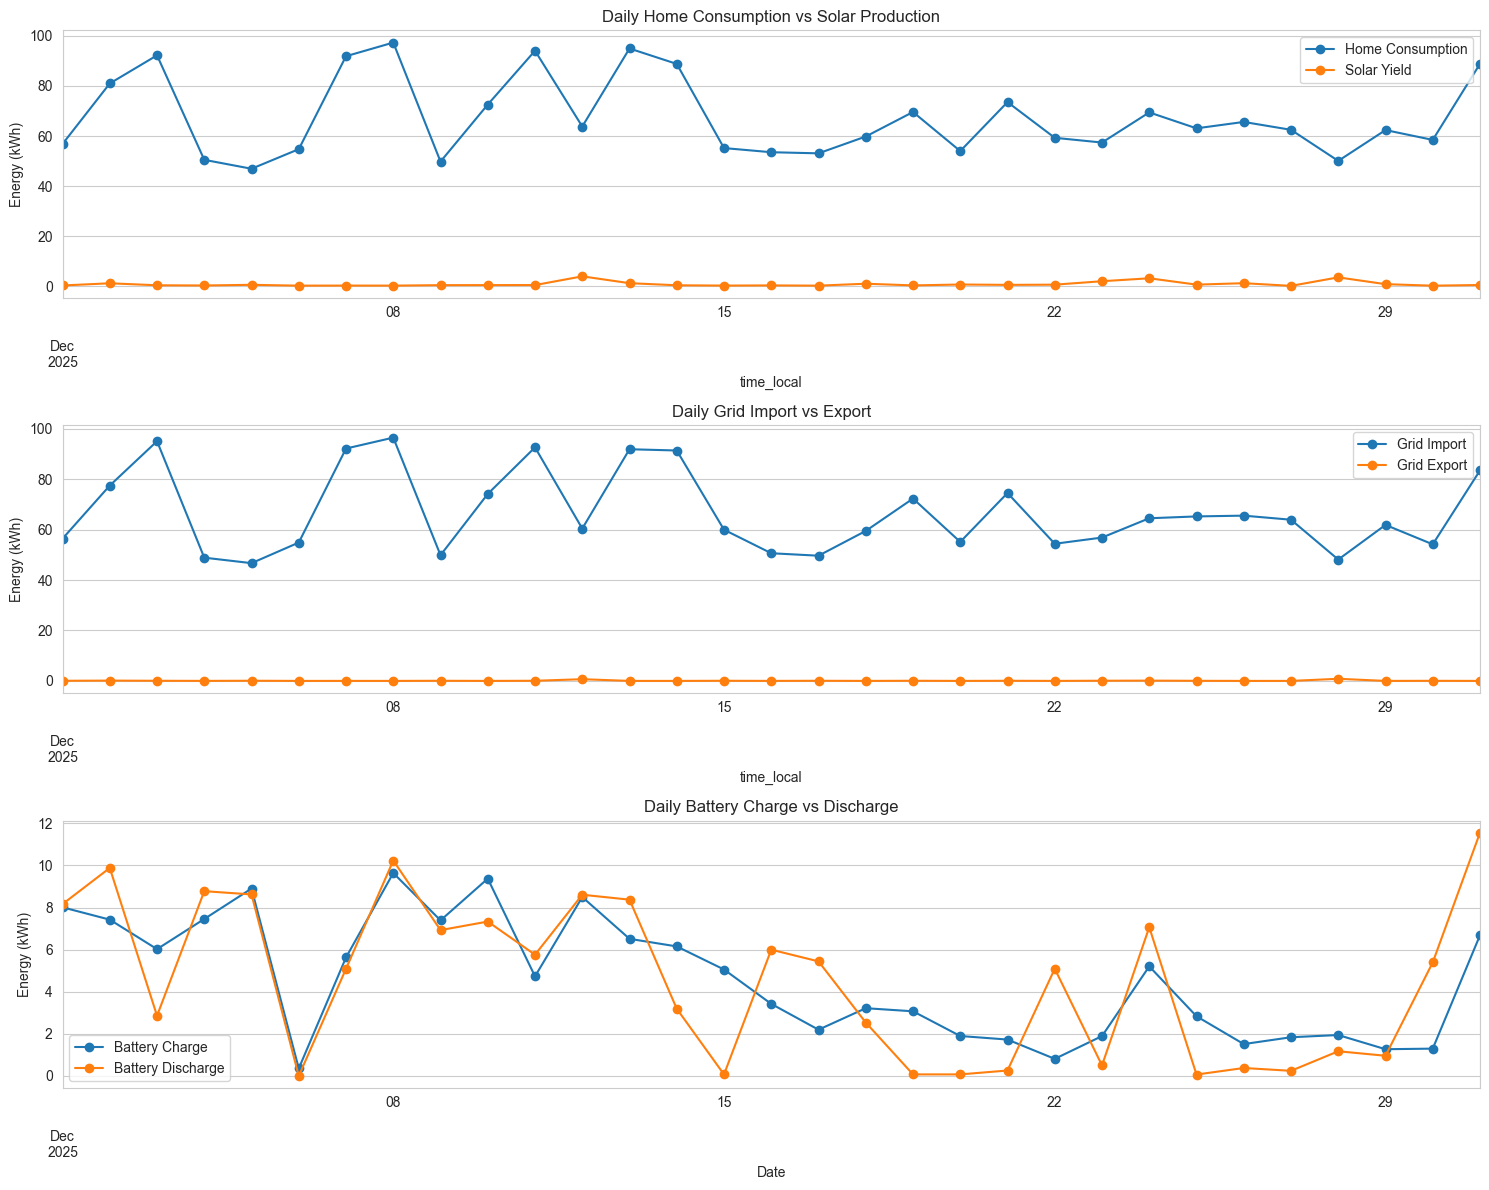

In [17]:
# Plot daily energy flows
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Consumption and Solar
ax1 = axes[0]
df_daily_15min[['HomeConsumption_kWh', 'SolarYield_kWh']].plot(ax=ax1, marker='o')
ax1.set_ylabel('Energy (kWh)')
ax1.set_title('Daily Home Consumption vs Solar Production')
ax1.legend(['Home Consumption', 'Solar Yield'])
ax1.grid(True)

# Plot 2: Grid Import/Export
ax2 = axes[1]
df_daily_15min[['EnergyImport_kWh', 'EnergyExport_kWh']].plot(ax=ax2, marker='o')
ax2.set_ylabel('Energy (kWh)')
ax2.set_title('Daily Grid Import vs Export')
ax2.legend(['Grid Import', 'Grid Export'])
ax2.grid(True)

# Plot 3: Battery Charge/Discharge
ax3 = axes[2]
df_daily_15min[['BatteryCharge_kWh', 'BatteryDischarge_kWh']].plot(ax=ax3, marker='o')
ax3.set_ylabel('Energy (kWh)')
ax3.set_xlabel('Date')
ax3.set_title('Daily Battery Charge vs Discharge')
ax3.legend(['Battery Charge', 'Battery Discharge'])
ax3.grid(True)

plt.tight_layout()
plt.show()

## Visualization: Daily Costs and Savings

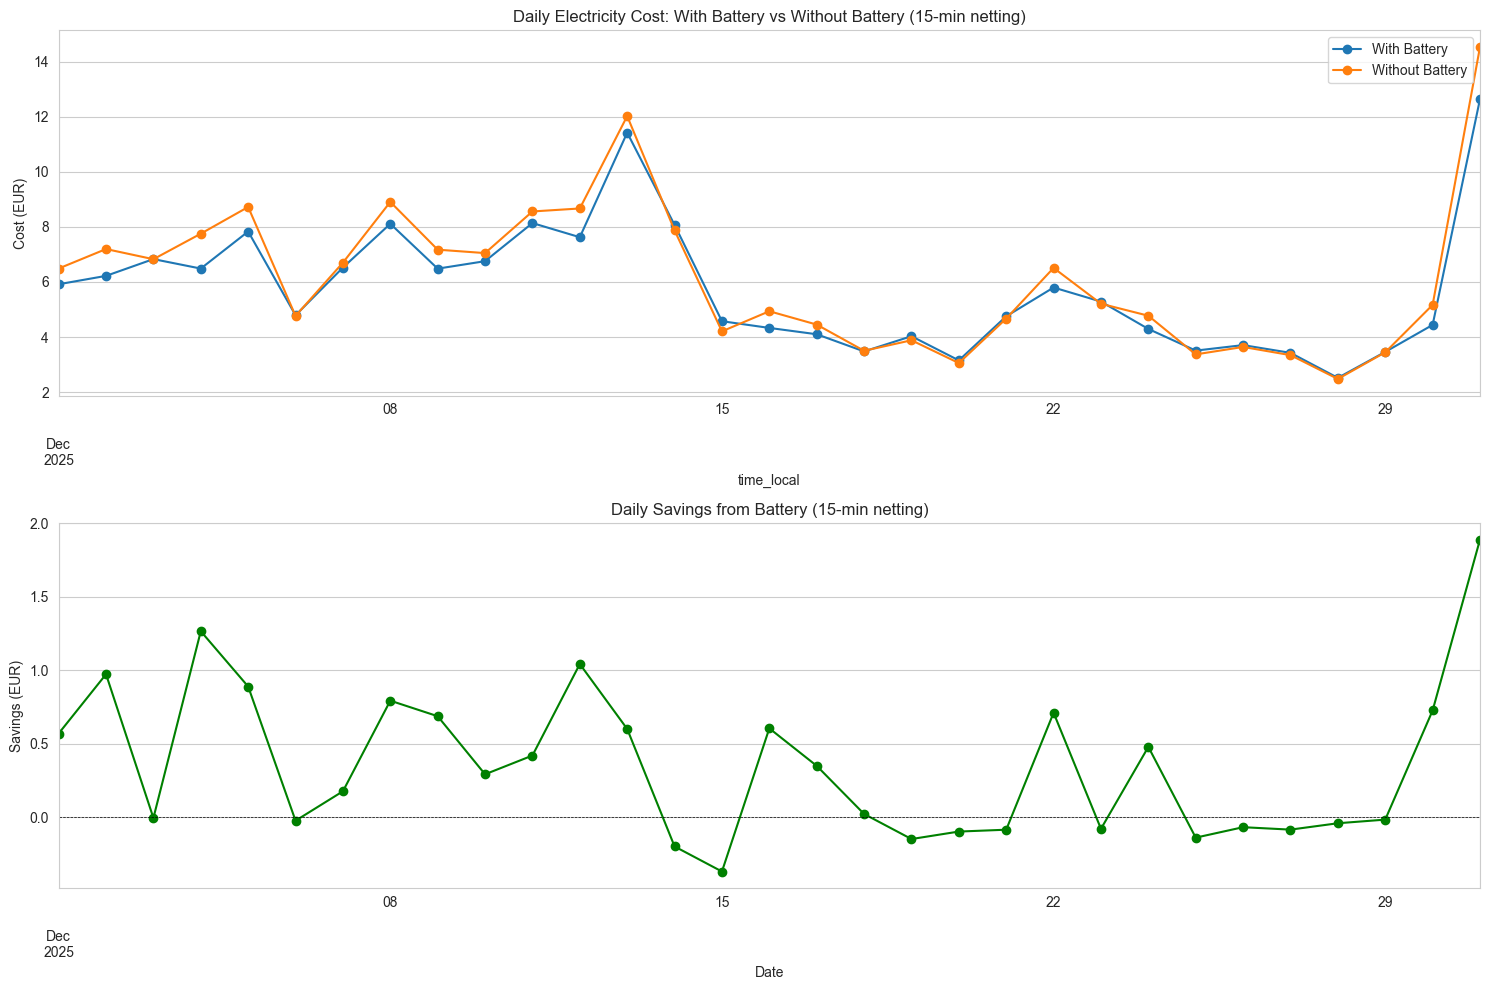

In [18]:
# Plot daily costs and savings
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Daily costs
ax1 = axes[0]
df_daily_15min[['Cost_WithBattery', 'Cost_NoBattery']].plot(ax=ax1, marker='o')
ax1.set_ylabel('Cost (EUR)')
ax1.set_title('Daily Electricity Cost: With Battery vs Without Battery (15-min netting)')
ax1.legend(['With Battery', 'Without Battery'])
ax1.grid(True)

# Plot 2: Daily savings
ax2 = axes[1]
df_daily_15min['Savings'].plot(ax=ax2, marker='o', color='green')
ax2.set_ylabel('Savings (EUR)')
ax2.set_xlabel('Date')
ax2.set_title('Daily Savings from Battery (15-min netting)')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax2.grid(True)

plt.tight_layout()
plt.show()

## Visualization: Battery Efficiency Over Time

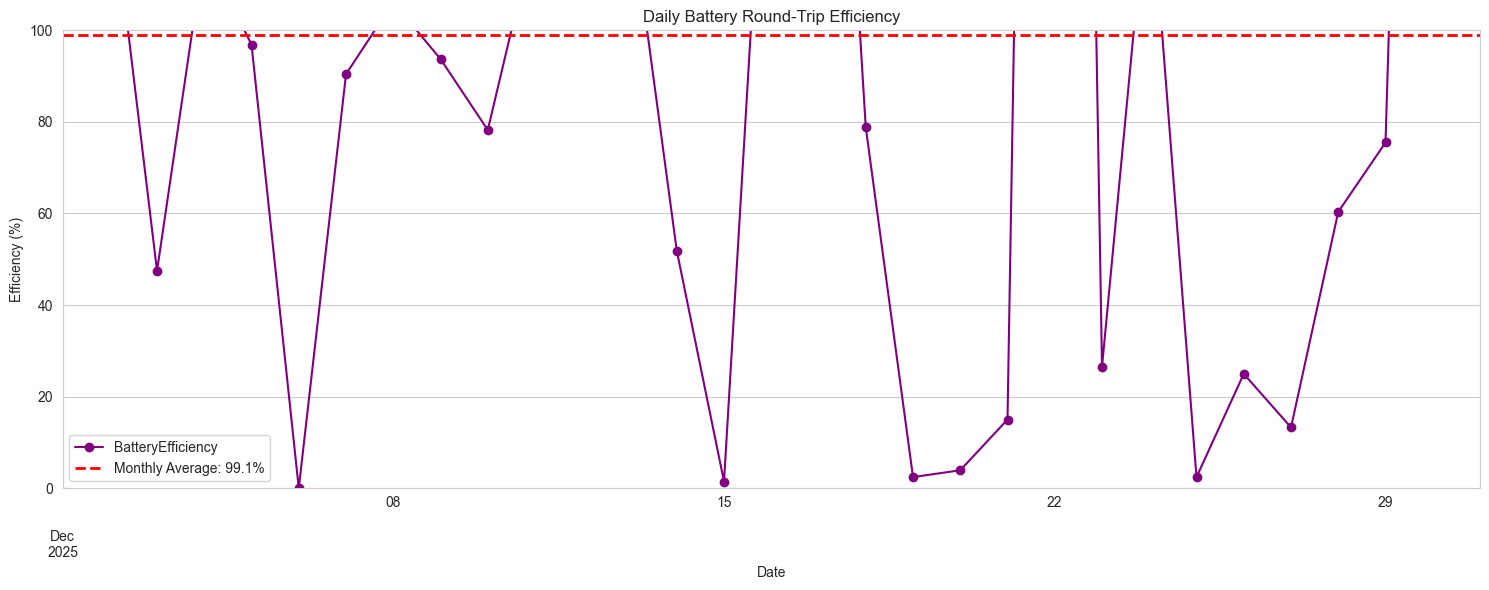

In [19]:
# Plot daily battery efficiency
fig, ax = plt.subplots(figsize=(15, 6))

# Filter out days with no battery activity
df_efficiency = df_daily_15min[df_daily_15min['BatteryCharge_kWh'] > 0].copy()

df_efficiency['BatteryEfficiency'].plot(ax=ax, marker='o', color='purple')
ax.axhline(y=battery_efficiency, color='red', linestyle='--', linewidth=2, 
           label=f'Monthly Average: {battery_efficiency:.1f}%')
ax.set_ylabel('Efficiency (%)')
ax.set_xlabel('Date')
ax.set_title('Daily Battery Round-Trip Efficiency')
ax.set_ylim(0, 100)
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

## Monthly Summary

In [20]:
# Create comprehensive summary
print('\n' + '='*60)
print(f'MONTHLY SUMMARY: {start_local.strftime("%B %Y")}')
print('='*60)

print('\n--- ENERGY FLOWS ---')
print(f'Total home consumption: {df_checkwatt["HomeConsumption"].sum() / 1000:.2f} kWh')
print(f'Total solar yield: {df_checkwatt["SolarYield_Wh"].sum() / 1000:.2f} kWh')
print(f'Total grid import: {df_checkwatt["EnergyImport_Wh"].sum() / 1000:.2f} kWh')
print(f'Total grid export: {df_checkwatt["EnergyExport_Wh"].sum() / 1000:.2f} kWh')
print(f'Net grid import: {(df_checkwatt["EnergyImport_Wh"].sum() - df_checkwatt["EnergyExport_Wh"].sum()) / 1000:.2f} kWh')

print('\n--- BATTERY PERFORMANCE ---')
print(f'Total battery charge: {total_charge_kwh:.2f} kWh')
print(f'Total battery discharge: {total_discharge_kwh:.2f} kWh')
print(f'Round-trip efficiency: {battery_efficiency:.1f}%')
print(f'Energy loss in battery: {total_charge_kwh - total_discharge_kwh:.2f} kWh')
print(f'Max charge power: {max_charge_watts:.0f} W ({max_charge_watts/1000:.2f} kW)')
print(f'Max discharge power: {max_discharge_watts:.0f} W ({max_discharge_watts/1000:.2f} kW)')
print(f'Estimated battery cycles: {battery_cycles:.1f}')

print('\n--- STATE OF CHARGE ---')
print(f'Minimum SoC: {soc_min:.1f}%')
print(f'Maximum SoC: {soc_max:.1f}%')
print(f'Average SoC: {soc_mean:.1f}%')

print('\n--- COST ANALYSIS (15-min netting) ---')
print(f'Total cost with battery: {df_15min["Cost_WithBattery"].sum():.2f} EUR')
print(f'Total cost without battery: {df_15min["Cost_NoBattery"].sum():.2f} EUR')
print(f'Total savings: {df_15min["Savings"].sum():.2f} EUR')
print(f'Savings percentage: {(df_15min["Savings"].sum() / df_15min["Cost_NoBattery"].sum() * 100):.1f}%')
print(f'Average daily savings: {df_15min["Savings"].sum() / num_days:.2f} EUR')
print(f'Projected annual savings: {df_15min["Savings"].sum() / num_days * 365:.2f} EUR')

print('\n--- COST ANALYSIS (1-hour netting) ---')
print(f'Total cost with battery: {df_1hour["Cost_WithBattery"].sum():.2f} EUR')
print(f'Total cost without battery: {df_1hour["Cost_NoBattery"].sum():.2f} EUR')
print(f'Total savings: {df_1hour["Savings"].sum():.2f} EUR')
print(f'Savings percentage: {(df_1hour["Savings"].sum() / df_1hour["Cost_NoBattery"].sum() * 100):.1f}%')
print(f'Average daily savings: {df_1hour["Savings"].sum() / num_days:.2f} EUR')
print(f'Projected annual savings: {df_1hour["Savings"].sum() / num_days * 365:.2f} EUR')

print('\n--- SPOT PRICES ---')
print(f'Average price: {df_spotprice["price_total"].mean():.4f} EUR/kWh')
print(f'Min price: {df_spotprice["price_total"].min():.4f} EUR/kWh')
print(f'Max price: {df_spotprice["price_total"].max():.4f} EUR/kWh')

print('\n' + '='*60)


MONTHLY SUMMARY: December 2025

--- ENERGY FLOWS ---
Total home consumption: 2091.20 kWh
Total solar yield: 27.12 kWh
Total grid import: 2067.74 kWh
Total grid export: 2.38 kWh
Net grid import: 2065.36 kWh

--- BATTERY PERFORMANCE ---
Total battery charge: 141.98 kWh
Total battery discharge: 140.70 kWh
Round-trip efficiency: 99.1%
Energy loss in battery: 1.28 kWh
Max charge power: 8760 W (8.76 kW)
Max discharge power: 8280 W (8.28 kW)
Estimated battery cycles: 7.0

--- STATE OF CHARGE ---
Minimum SoC: 26.0%
Maximum SoC: 74.0%
Average SoC: 54.2%

--- COST ANALYSIS (15-min netting) ---
Total cost with battery: 178.73 EUR
Total cost without battery: 189.90 EUR
Total savings: 11.17 EUR
Savings percentage: 5.9%
Average daily savings: 0.36 EUR
Projected annual savings: 131.58 EUR

--- COST ANALYSIS (1-hour netting) ---
Total cost with battery: 179.47 EUR
Total cost without battery: 190.05 EUR
Total savings: 10.58 EUR
Savings percentage: 5.6%
Average daily savings: 0.34 EUR
Projected annual 

## Export Results

In [21]:
# Export results to CSV
output_dir = '../data/analysis_results'
os.makedirs(output_dir, exist_ok=True)

month_str = start_local.strftime('%Y-%m')

df_daily_15min.to_csv(f'{output_dir}/monthly_daily_summary_{month_str}.csv')
df_15min.to_csv(f'{output_dir}/monthly_15min_data_{month_str}.csv')
df_1hour.to_csv(f'{output_dir}/monthly_1hour_data_{month_str}.csv')

# Export summary statistics
summary_dict = {
    'Month': month_str,
    'Days': num_days,
    'Total_Consumption_kWh': df_checkwatt['HomeConsumption'].sum() / 1000,
    'Total_Solar_kWh': df_checkwatt['SolarYield_Wh'].sum() / 1000,
    'Total_Grid_Import_kWh': df_checkwatt['EnergyImport_Wh'].sum() / 1000,
    'Total_Grid_Export_kWh': df_checkwatt['EnergyExport_Wh'].sum() / 1000,
    'Battery_Charge_kWh': total_charge_kwh,
    'Battery_Discharge_kWh': total_discharge_kwh,
    'Battery_Efficiency_%': battery_efficiency,
    'Battery_Max_Charge_W': max_charge_watts,
    'Battery_Max_Discharge_W': max_discharge_watts,
    'Battery_Cycles': battery_cycles,
    'SoC_Min_%': soc_min,
    'SoC_Max_%': soc_max,
    'SoC_Avg_%': soc_mean,
    'Cost_WithBattery_15min_EUR': df_15min['Cost_WithBattery'].sum(),
    'Cost_NoBattery_15min_EUR': df_15min['Cost_NoBattery'].sum(),
    'Savings_15min_EUR': df_15min['Savings'].sum(),
    'Savings_15min_%': (df_15min['Savings'].sum() / df_15min['Cost_NoBattery'].sum() * 100),
    'Cost_WithBattery_1hour_EUR': df_1hour['Cost_WithBattery'].sum(),
    'Cost_NoBattery_1hour_EUR': df_1hour['Cost_NoBattery'].sum(),
    'Savings_1hour_EUR': df_1hour['Savings'].sum(),
    'Savings_1hour_%': (df_1hour['Savings'].sum() / df_1hour['Cost_NoBattery'].sum() * 100),
    'Avg_Price_EUR_kWh': df_spotprice['price_total'].mean()
}

df_summary = pd.DataFrame([summary_dict])
df_summary.to_csv(f'{output_dir}/monthly_summary_{month_str}.csv', index=False)

print(f'Results exported to {output_dir}/')
print(f'  - monthly_daily_summary_{month_str}.csv')
print(f'  - monthly_15min_data_{month_str}.csv')
print(f'  - monthly_1hour_data_{month_str}.csv')
print(f'  - monthly_summary_{month_str}.csv')

Results exported to ../data/analysis_results/
  - monthly_daily_summary_2025-12.csv
  - monthly_15min_data_2025-12.csv
  - monthly_1hour_data_2025-12.csv
  - monthly_summary_2025-12.csv
